In [62]:
import matplotlib.pyplot as plt
import scipy.integrate
import numpy as np
from scipy.optimize import fsolve

In [68]:
def fhn(t, x, i_stim):
    V, w = x
    # fixed params for class 2
    C = 2
    E_Na = 50
    E_K = -100
    E_leak = -70
    g_fast = 20
    g_slow = 20
    g_leak = 2
    beta_m = -1.2
    beta_w = -13
    X_m = 18
    X_w = 10
    phi_w = 0.15

    # Steady-state curves
    m_inf = 0.5 * (1 + np.tanh((V - beta_m) / X_m))
    w_inf = 0.5 * (1 + np.tanh((V - beta_w) / X_w))
    tau_w = 1 / np.cosh((V - beta_w) / (2 * X_w))
    
    # ODEs
    dVdt = (i_stim - g_fast * m_inf * (V - E_Na) - g_slow * w * (V - E_K) - g_leak * (V - E_leak)) / C
    dwdt = phi_w * (w_inf - w)/tau_w

    return [dVdt, dwdt]

In [14]:
def plot_nullclines(func, i_stim, xlo, xhi, nx, ylo, yhi, ny, ax=None):
    # Evaluate the ODE function at each point on a coordinate grid
    xx, yy = np.meshgrid(np.linspace(xlo, xhi, nx), np.linspace(ylo, yhi, ny))
    coords = np.c_[xx.ravel(), yy.ravel()]
    ode_rhs = np.array([func(0, coord, i_stim) for coord in coords])

    
    # 2d arrays of v_dot and w_dot at each coordinate grid-point
    v_dot = ode_rhs[:, 0].reshape(xx.shape)
    w_dot = ode_rhs[:, 1].reshape(yy.shape)

    if not ax:
        _, ax = plt.subplots()

    ax.contour(xx, yy, v_dot, levels=0, colors="red")  # V-nullcline
    ax.contour(xx, yy, w_dot, levels=0, colors="green") # w-nullcline

    return ax

In [15]:
def plot_trajectory(func, initial_cond, i_stim, transient_time, sim_time, ax=None, **plot_kwargs):
    # Integrate for a bit to get rid of transients
    soln = scipy.integrate.solve_ivp(
        lambda t, x: func(t, x, i_stim),
        [-transient_time, 0],
        initial_cond,
    )
    # Integrate again from the previous state
    soln = scipy.integrate.solve_ivp(
        lambda t, x: func(t, x, i_stim),
        [0, sim_time],
        soln.y[:, -1],
        atol=1e-9,
        rtol=1e-9,
    )

    if not ax:
        _, ax = plt.subplots()

    ax.plot(soln.y[0], soln.y[1], **plot_kwargs)

    return ax

In [16]:
def plot_flow_field(func, i_stim, xlo, xhi, nx, ylo, yhi, ny, ax=None):
    # Evaluate the ODE function at each point on a coordinate grid
    xx, yy = np.meshgrid(np.linspace(xlo, xhi, nx), np.linspace(ylo, yhi, ny))
    coords = np.c_[xx.ravel(), yy.ravel()]
    ode_rhs = np.array([func(0, coord, i_stim) for coord in coords])

    # 2d arrays of v_dot and w_dot at each coordinate grid-point
    v_dot = ode_rhs[:, 0].reshape(xx.shape)
    w_dot = ode_rhs[:, 1].reshape(yy.shape)

    if not ax:
        _, ax = plt.subplots()

    ax.quiver(xx, yy, v_dot, w_dot)

    return ax 

/var/folders/6x/14_q_lxs4dq9z_3t871f4lyw0000gp/T/ipykernel_82264/1826354544.py:20: RuntimeWarning: overflow encountered in cosh
  tau_w = 1 / np.cosh((V - beta_w) / (2 * X_w))
/var/folders/6x/14_q_lxs4dq9z_3t871f4lyw0000gp/T/ipykernel_82264/1826354544.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  dwdt = phi_w * (w_inf - w)/tau_w


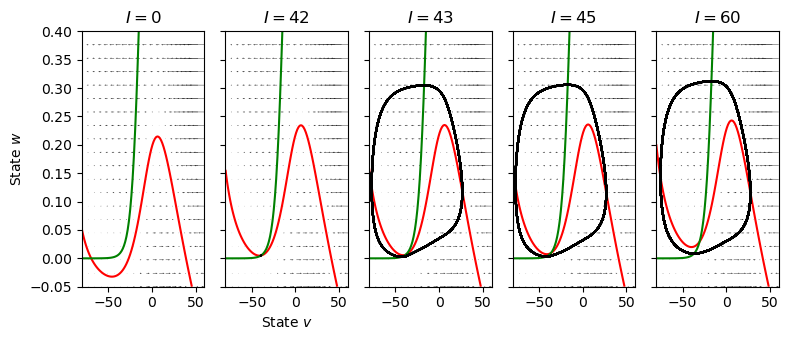

In [96]:
def main():
    pars = [0, 42, 43, 45, 60]
    _, axarr = plt.subplots(1, len(pars), figsize=(8, 3.5), sharex=True, sharey=True)

    for ax, par in zip(axarr, pars):
        plot_nullclines(fhn, par, xlo=-80, xhi=60, nx=100, ylo=-0.05, yhi=0.4, ny=100, ax=ax)
        plot_flow_field(fhn, par, xlo=-80, xhi=60, nx=20, ylo=-0.05, yhi=0.4, ny=20, ax=ax)
        plot_trajectory(
            fhn,
            initial_cond=[-80, 0.1],
            i_stim=par,
            transient_time=100,
            sim_time=200,
            ax=ax,
            color="k",
        )
        ax.set_title(f"$I={par}$")
    axarr[1].set_xlabel("State $v$")
    axarr[0].set_ylabel("State $w$")
    plt.tight_layout()
    plt.savefig("phase_planes_plot.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    main()

In [89]:
#Get V_max and V_min for a given I_stim
def get_voltage_extrema(i_stim, t_trans=100, t_sim=200, init=[-80, 0.1]):
    #remove transients initial spike
    sol_pre = scipy.integrate.solve_ivp(
        lambda t, x: fhn(t, x, i_stim),
        [-t_trans, 0],
        init
    )
    # Main sim
    sol = scipy.integrate.solve_ivp(
        lambda t, x: fhn(t, x, i_stim),
        [0, t_sim],
        sol_pre.y[:, -1],
        t_eval=np.linspace(0, t_sim, 3000)
    )
    V = sol.y[0]
    return np.max(V), np.min(V)

In [90]:
#fixed point system for fsolve to find unstable equilibrium points (where dV/dt = 0, dw/dt = 0)
def steady_state_system(vars, i_stim):
    V, w = vars
    dV = (i_stim - g_fast * m_inf(V) * (V - E_Na)- g_slow * w * (V - E_K) - g_leak * (V - E_leak)) / C
    dw = phi_w * (w_inf(V) - w) / tau_w(V)
    return [dV, dw]

In [97]:
# iterate over i_stim values of interest (just before and after spiking class 2)
i_vals = np.linspace(35, 60, 100)
v_max_vals = []
v_min_vals = []
v_fixed_points = []

t_span = [0, 500]
t_eval = np.linspace(*t_span, 500)
init = [-80, 0.1]

for i in i_vals:
    #simulate for max and min
    sol = scipy.integrate.solve_ivp(
        lambda t, x: fhn(t, x, i),
        t_span, init, t_eval=t_eval
    )
    V = sol.y[0][int(len(t_eval) * 0.5):]  #remove transient initial spike
    v_max_vals.append(np.max(V))
    v_min_vals.append(np.min(V))

    #fixed point calculation for equilibrium unstable line
    root = fsolve(steady_state_system, [-60, 0.1], args=(i,))
    v_fixed_points.append(root[0])


/var/folders/6x/14_q_lxs4dq9z_3t871f4lyw0000gp/T/ipykernel_82264/1826354544.py:20: RuntimeWarning: overflow encountered in cosh
  tau_w = 1 / np.cosh((V - beta_w) / (2 * X_w))
/var/folders/6x/14_q_lxs4dq9z_3t871f4lyw0000gp/T/ipykernel_82264/1826354544.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  dwdt = phi_w * (w_inf - w)/tau_w


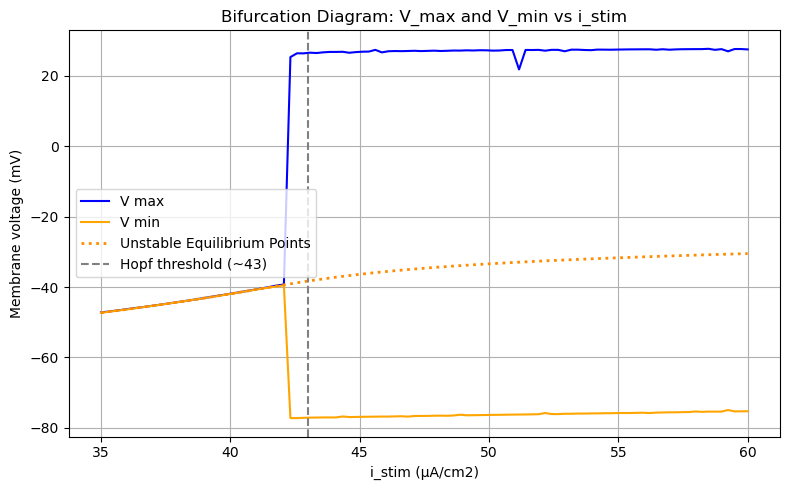

In [109]:
# plot bifurcation
plt.figure(figsize=(8, 5))
plt.plot(i_vals, v_max_vals, label="V max", color="blue")
plt.plot(i_vals, v_min_vals, label="V min", color="orange")
plt.plot(i_vals, v_fixed_points, linestyle=':', color='darkorange', linewidth=2.0, label='Unstable Equilibrium Points')

plt.axvline(43, linestyle="--", color="gray", label="Hopf threshold (~43)")
#plt.axvline(x=50, color='gray', linestyle=':', label='High I_stim (~50)')

plt.xlabel("i_stim (μA/cm2)")
plt.ylabel("Membrane voltage (mV)")
plt.title("Bifurcation Diagram: V_max and V_min vs i_stim")

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("bifurcation.png", dpi=300)
plt.show()

In [37]:
#make spike counter
def count_spikes(V, threshold=0):
    return np.sum((V[:-1] < threshold) & (V[1:] >= threshold))

In [100]:
# build f-i curve for range of i_stim
def fi_curve_2d(model_func, stim_range, sim_time=100, init=[-80, 0.1]):
    t_eval = np.linspace(0, sim_time, 3000)
    freqs = []

    for i in stim_range:
        sol = scipy.integrate.solve_ivp(
            lambda t, x: model_func(t, x, i),
            [0, sim_time],
            init,
            t_eval=t_eval
        )
        V = sol.y[0]
        n_spikes = count_spikes(V)
        freq = n_spikes / (sim_time / 1000)  # Hz
        freqs.append(freq)

    return stim_range, freqs

/var/folders/6x/14_q_lxs4dq9z_3t871f4lyw0000gp/T/ipykernel_82264/1826354544.py:20: RuntimeWarning: overflow encountered in cosh
  tau_w = 1 / np.cosh((V - beta_w) / (2 * X_w))
/var/folders/6x/14_q_lxs4dq9z_3t871f4lyw0000gp/T/ipykernel_82264/1826354544.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  dwdt = phi_w * (w_inf - w)/tau_w


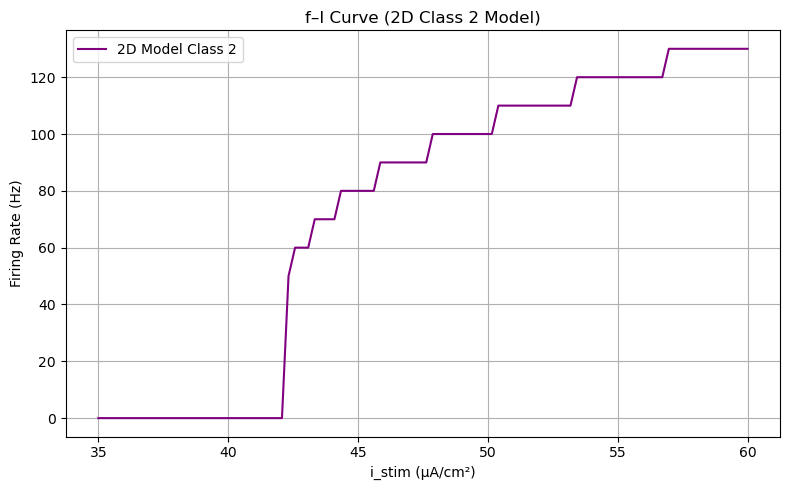

In [103]:
#set stim range and plot
stim_range = np.linspace(35, 60, 100)
I_vals, freq_vals = generate_fi_curve_2d(fhn, stim_range)

plt.figure(figsize=(8, 5))
plt.plot(I_vals, freq_vals, label="2D Model Class 2", color="purple")
plt.xlabel("i_stim (μA/cm²)")
plt.ylabel("Firing Rate (Hz)")
plt.title("f–I Curve (2D Class 2 Model)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("f-i curve.png", dpi=300)
plt.show()

In [104]:
#create heatmap for varying v and b_w
def model_2d_vary_bw(t, x, I_stim, beta_w):
    V, w = x

    #params
    C = 2
    E_Na = 50
    E_K = -100
    E_leak = -70
    g_fast = 20
    g_slow = 20
    g_leak = 2
    beta_m = -1.2
    X_m = 18
    X_w = 10
    phi_w = 0.15

    # Activation and tau_w using variable beta_w
    m_inf = 0.5 * (1 + np.tanh((V - beta_m) / X_m))
    w_inf = 0.5 * (1 + np.tanh((V - beta_w) / X_w))
    tau_w = 1 / np.cosh((V - beta_w) / (2 * X_w))

    dVdt = (I_stim
            - g_fast * m_inf * (V - E_Na)
            - g_slow * w * (V - E_K)
            - g_leak * (V - E_leak)) / C
    dwdt = phi_w * (w_inf - w) / tau_w
    return [dVdt, dwdt]

In [105]:
# simulate and record firing rate for given i_stim and beta_w
def get_firing_rate(i_stim, beta_w, sim_time=300, init=[-80, 0.1]):
    t_eval = np.linspace(0, sim_time, 3000)
    sol = scipy.integrate.solve_ivp(
        lambda t, x: model_2d_vary_bw(t, x, i_stim, beta_w),
        [0, sim_time],
        init,
        t_eval=t_eval
    )
    V = sol.y[0]
    return count_spikes(V) / (sim_time / 1000)

In [106]:
# iterate over ranges of i_stim and beta_w
beta_w_vals = np.linspace(-25, 0, 100) 
i_stim_vals = np.linspace(30, 80, 81)

firing_matrix = np.zeros((len(i_stim_vals), len(beta_w_vals)))

for i, I in enumerate(i_stim_vals):
    for j, bw in enumerate(beta_w_vals):
        firing_matrix[i, j] = get_firing_rate(I, bw)


/var/folders/6x/14_q_lxs4dq9z_3t871f4lyw0000gp/T/ipykernel_82264/666081926.py:21: RuntimeWarning: overflow encountered in cosh
  tau_w = 1 / np.cosh((V - beta_w) / (2 * X_w))
/var/folders/6x/14_q_lxs4dq9z_3t871f4lyw0000gp/T/ipykernel_82264/666081926.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  dwdt = phi_w * (w_inf - w) / tau_w
/var/folders/6x/14_q_lxs4dq9z_3t871f4lyw0000gp/T/ipykernel_82264/666081926.py:27: RuntimeWarning: overflow encountered in scalar divide
  dwdt = phi_w * (w_inf - w) / tau_w
/var/folders/6x/14_q_lxs4dq9z_3t871f4lyw0000gp/T/ipykernel_82264/666081926.py:25: RuntimeWarning: overflow encountered in scalar multiply
  - g_slow * w * (V - E_K)
/var/folders/6x/14_q_lxs4dq9z_3t871f4lyw0000gp/T/ipykernel_82264/666081926.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  - g_fast * m_inf * (V - E_Na)


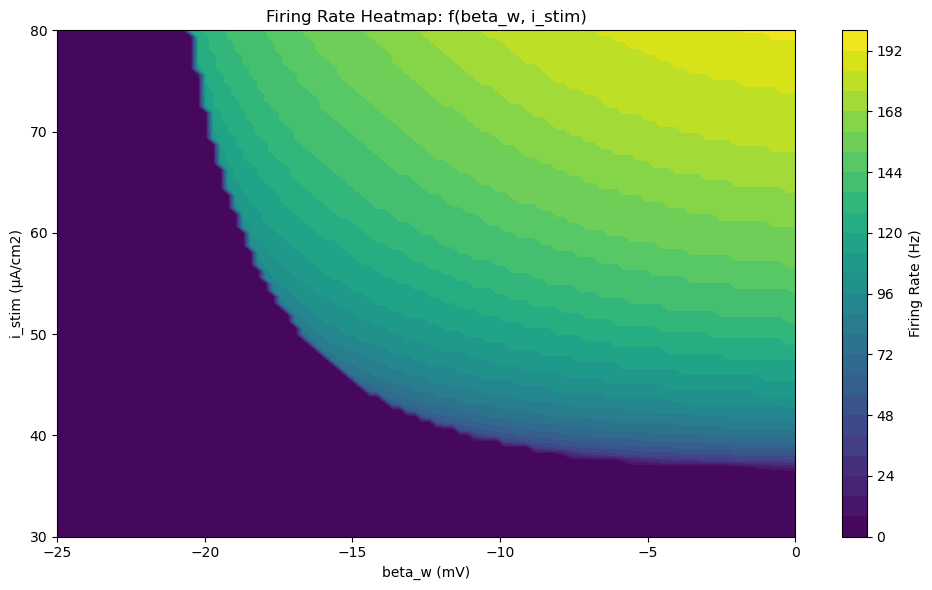

In [110]:
#plot heatmap
plt.figure(figsize=(10, 6))
plt.contourf(beta_w_vals, i_stim_vals, firing_matrix, levels=30, cmap="viridis")
plt.colorbar(label="Firing Rate (Hz)")
plt.xlabel("beta_w (mV)")
plt.ylabel("i_stim (μA/cm2)")
plt.title("Firing Rate Heatmap: f(beta_w, i_stim)")
plt.tight_layout()
plt.savefig("heatmap_class2.png", dpi=300)
plt.show()